## Individual Subcomponent test for ML - Week 6

#### Dataset : https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

`30` subjects & `12` activities.
3-axial linear acceleration and 3-axial angular velocity at a constant rate of `50Hz` using the embedded accelerometer and gyroscope of the device. 

The obtained dataset was randomly partitioned into two sets, where `70%` of the volunteers was selected for generating the `training data` and `30%` the `test data`.

- The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width `sliding windows of 2.56 sec` and `50% overlap (128 readings/window)`. 
- The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. 
- The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 
- From `each window`, a vector of `561 features` was obtained by calculating variables from the time and frequency domain. 

#### References : 
- https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/
- https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/
- https://deeplizard.com/learn/video/0LhiS6yu2qQ
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- https://towardsdatascience.com/multiclass-classification-using-k-nearest-neighbours-ca5281a9ef76





In [410]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
import seaborn as sn
plt.style.use('ggplot')
sn.set_style("whitegrid")
%matplotlib inline

In [411]:
# Read in activity num & labels as a df
activity_label_df = pd.read_csv('../data2/HAPT Data Set/activity_labels.txt',delim_whitespace=True, header=None)
activity_num = np.arange(0,12)
labels = np.array(activity_label_df[1])
print(f"labels : {labels}")
print(f"activity_num : {activity_num}")

# Read in features extracted as a df 
features_df = pd.read_csv('../data2/HAPT Data Set/features.txt',delim_whitespace=True, header=None)
features = np.array(features_df[0])
# print(f"features : {features}")
print(f"Total number of training feature columns : {features.size}")

# create map of activity num to activity name 
map_num_to_activity = {}
for i,num in enumerate(activity_num):
    map_num_to_activity[num] = labels[i]
map_num_to_activity

labels : ['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING' 'STAND_TO_SIT' 'SIT_TO_STAND' 'SIT_TO_LIE' 'LIE_TO_SIT'
 'STAND_TO_LIE' 'LIE_TO_STAND']
activity_num : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Total number of training feature columns : 561


{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING',
 6: 'STAND_TO_SIT',
 7: 'SIT_TO_STAND',
 8: 'SIT_TO_LIE',
 9: 'LIE_TO_SIT',
 10: 'STAND_TO_LIE',
 11: 'LIE_TO_STAND'}

### Load Training Set 

In [412]:
X = pd.read_csv('../data2/HAPT Data Set/Train/X_train.txt',delim_whitespace=True, header=None)
print(f"X shape when loaded from txt: {X.shape}")
X.columns = features
X['Subject'] = pd.read_csv('../data2/HAPT Data Set/Train/subject_id_train.txt', header=None, squeeze=True)
print(f"X shape after including subject number: {X.shape}")

y = pd.read_csv('../data2/HAPT Data Set/Train/y_train.txt', names=['Activity'], squeeze=True)
y = y-1
X['Activity'] = y
X['ActivityName'] = X["Activity"].map(map_num_to_activity)

print(f"X shape after including activity and activity name: {X.shape}")
print('No of duplicates in X: {}'.format(sum(X.duplicated())))
print('We have {} NaN/Null values in X'.format(X.isnull().values.sum()))

X_vals = X.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
X.sample()

X shape when loaded from txt: (7767, 561)
X shape after including subject number: (7767, 562)
X shape after including activity and activity name: (7767, 564)
No of duplicates in X: 0
We have 0 NaN/Null values in X


,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,Subject,Activity,ActivityName
7284,0.078659,-0.010354,-0.050178,-0.106728,-0.260156,-0.418688,-0.120884,-0.368883,-0.529985,0.049075,...,-0.523555,0.787628,-0.984984,0.153238,-0.868111,0.170168,-0.034275,29,0,WALKING


### Load Test Set 

In [413]:
# get the data from txt files to pandas dataffame
x_t = pd.read_csv('../data2/HAPT Data Set/Test/X_test.txt', delim_whitespace=True, header=None)
print(f"x_t shape when loaded from txt: {x_t.shape}")
x_t.columns = features

# add subject column to the dataframe
x_t['Subject'] = pd.read_csv('../data2/HAPT Data Set/Test/subject_id_test.txt', header=None, squeeze=True)
print(f"x_t shape after including subject number: {x_t.shape}")

# get y labels from the txt file
y_t = pd.read_csv('../data2/HAPT Data Set/Test/y_test.txt', names=['Activity'], squeeze=True)
y_t = y_t -1
x_t['Activity'] = y_t
x_t['ActivityName'] = x_t["Activity"].map(map_num_to_activity)

print(f"x_t shape after including activity and activity name: {x_t.shape}")
print('No of duplicates in x_t: {}'.format(sum(x_t.duplicated())))
print('We have {} NaN/Null values in x_t'.format(x_t.isnull().values.sum()))

x_tvals = x_t.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
x_t.sample()

x_t shape when loaded from txt: (3162, 561)
x_t shape after including subject number: (3162, 562)
x_t shape after including activity and activity name: (3162, 564)
No of duplicates in x_t: 0
We have 0 NaN/Null values in x_t


,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,Subject,Activity,ActivityName
1254,0.018978,0.074744,-0.089658,-0.136877,-0.412843,-0.056098,-0.197366,-0.457903,-0.187549,0.257771,...,0.098711,-0.418011,-0.904023,0.607019,-0.835402,0.001312,-0.043961,10,1,WALKING_UPSTAIRS


### Data Visualisation

In [414]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


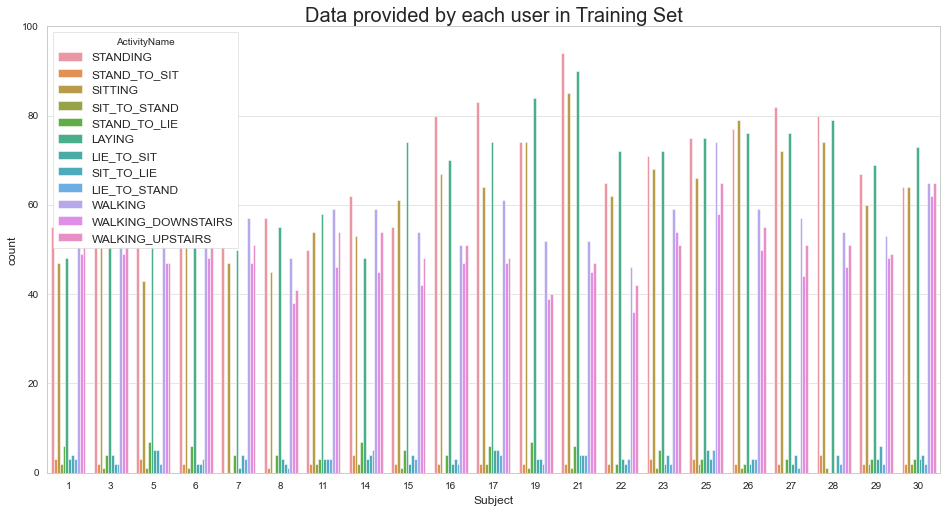

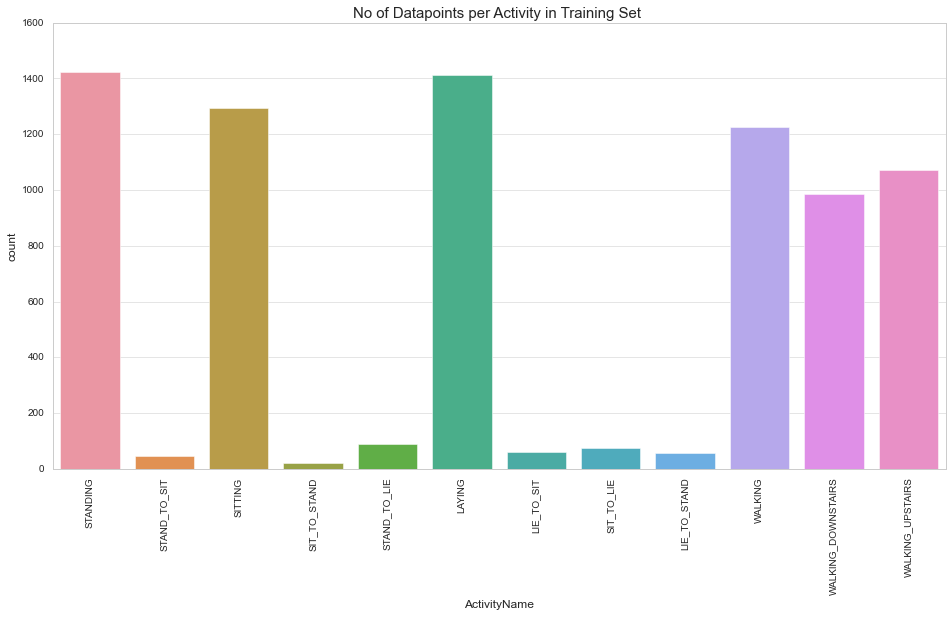

In [415]:
plt.figure(figsize = (16,8))
plt.title("Data provided by each user in Training Set", fontsize = 20)
sn.countplot(x ="Subject", hue ="ActivityName", data =X)
plt.show()

plt.figure(figsize = (16,8))
plt.title('No of Datapoints per Activity in Training Set ', fontsize=15)
sn.countplot(x = X["ActivityName"])
plt.xticks(rotation=90)
plt.show()

### Feature Selection

In [416]:
# train_x = X_train.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
# clf = ExtraTreesClassifier(criterion = "entropy", random_state = 0)
# clf = clf.fit(train_x, y_train)
# # for feature in zip(features, clf.feature_importances_):
# #     print(feature)
# sfm = SelectFromModel(clf)
# sfm.fit(train_x, y_train)

# for feature_list_index in sfm.get_support(indices=True):
#     print(features[feature_list_index])

In [417]:
# train_x.shape
# clf = ExtraTreesClassifier(criterion = "entropy", random_state = 42)
# clf = clf.fit(train_x, y_train)
# clf.feature_importances_ 
# model = SelectFromModel(clf, prefit=True)
# new_train = model.transform(train_x)
# new_train.shape

### Multi Layer Perceptron Model

#### Defining the MLP model

In [418]:
class Model(nn.Module):
    def __init__(self, in_features=561, h1=900, h2=250, out_features=12):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [419]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(32)
model = Model()
X_train = torch.FloatTensor(X_vals)
X_test = torch.FloatTensor(x_tvals)
y_train = torch.LongTensor(y)
y_test = torch.LongTensor(y_t)
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)
testloader = DataLoader(X_test, batch_size=60, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#### Training the model

epoch:  1  loss: 2.51732254
epoch: 11  loss: 1.45350361
epoch: 21  loss: 0.66780841
epoch: 31  loss: 0.40343362
epoch: 41  loss: 0.29073521
epoch: 51  loss: 0.20195378
epoch: 61  loss: 0.15383992
epoch: 71  loss: 0.11692660
epoch: 81  loss: 0.09534829
epoch: 91  loss: 0.08234937


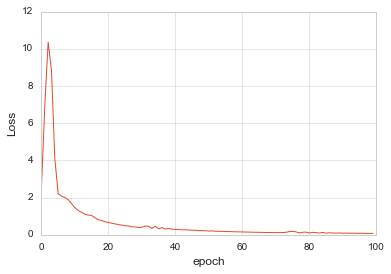

In [420]:
epochs = 100
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
with torch.no_grad():
    plt.plot(range(epochs), losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch')   

### Evaluation of MLP 

In [421]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
    print(f'Loss with test set : {loss:.8f}')
    
    

Loss with test set : 0.22755578


In [422]:
with torch.no_grad():
    preds = []
    correct = 0
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
#         print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
#         print(y_val.argmax().item(),y_test[i], y_val.argmax() )
        preds.append(y_val.argmax().item())
        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
    y_preds = torch.tensor(preds, dtype = torch.int64)
    stacked = torch.stack((y_test,y_preds),dim=1)
#     print(stacked.shape)
#     print(stacked)
    cmt = torch.zeros(12,12, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
#         print(tl,pl)
        cmt[tl, pl] = cmt[tl, pl] + 1   
#     print(cmt)


2911 out of 3162 = 92.06% correct


Confusion matrix, without normalization
tensor([[487,   3,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 13, 455,   1,   0,   0,   0,   2,   0,   0,   0,   0,   0],
        [  3,  37, 380,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   4,   0, 435,  69,   0,   0,   0,   0,   0,   0,   0],
        [  2,   0,   0,  25, 527,   0,   1,   0,   0,   0,   1,   0],
        [  1,   1,   0,  17,   0, 526,   0,   0,   0,   0,   0,   0],
        [  0,   2,   0,   2,   1,   0,  17,   0,   0,   0,   1,   0],
        [  0,   1,   0,   0,   0,   0,   0,   9,   0,   0,   0,   0],
        [  0,   1,   0,   0,   0,   0,   0,   0,  21,   0,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   1,  17,   0,   7],
        [  0,   0,   0,   1,   1,   1,   2,   0,  14,   1,  29,   0],
        [  0,   0,   0,   0,   0,   0,   1,   0,   1,  16,   1,   8]])


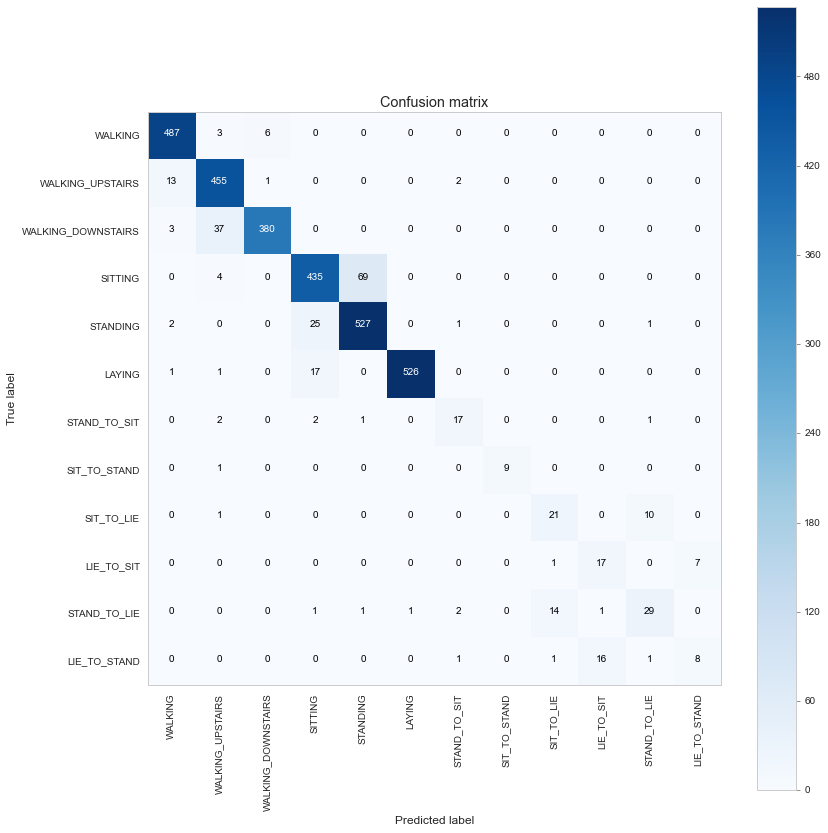

In [423]:
plt.figure(figsize=(12,12))
plot_confusion_matrix(cmt, labels)

In [424]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       496
           1       0.90      0.97      0.93       471
           2       0.98      0.90      0.94       420
           3       0.91      0.86      0.88       508
           4       0.88      0.95      0.91       556
           5       1.00      0.97      0.98       545
           6       0.74      0.74      0.74        23
           7       1.00      0.90      0.95        10
           8       0.57      0.66      0.61        32
           9       0.50      0.68      0.58        25
          10       0.69      0.59      0.64        49
          11       0.53      0.30      0.38        27

    accuracy                           0.92      3162
   macro avg       0.81      0.79      0.79      3162
weighted avg       0.92      0.92      0.92      3162

